In [2]:
%load_ext autoreload
import sys
sys.path.append("..")

In [3]:
%matplotlib inline

In [52]:
import matplotlib.pyplot as plt

import numpy as np

import darkhistory.physics as phys
import main
# import darkhistory.history.tla as tla

In [61]:
%autoreload

rs_vec = np.flipud(np.arange(5, 3000, 1))

def func(rs):
    
    if isinstance(rs, np.ndarray):
    
        xe_to_return = np.zeros_like(rs)
        xe_to_return[np.where(rs < 7)] = 1

        return xe_to_return
    
    else:
        
        if rs > 7:
            
            return 0
        
        else:
            
            return 1.

test2 = main.evolve(
    start_rs=3000, coarsen_factor=12,
    DM_process='decay', mDM=2e4, lifetime=1e24, primary='phot_delta',
    reion_switch = True, reion_rs = 7, xe_reion_func=func,
    backreaction=False, compute_fs_method='He'
)

1 1 1 [False  True]
0 0 0 [ True  True]


IndexError: index -1 is out of bounds for axis 0 with size 0

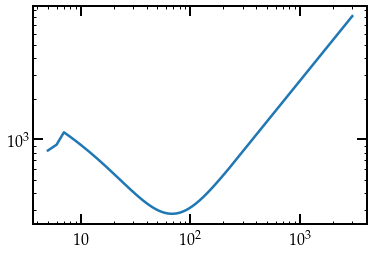

In [51]:
plt.figure()

plt.loglog()

plt.plot(rs_vec, test2[:,0]/phys.kB)

In [53]:
?main.evolve

In [24]:
test

array([[7.04232739e-01, 9.99999999e-01, 9.99998695e-13, 9.99998695e-13],
       [7.04126271e-01, 9.99999999e-01, 9.99998695e-13, 9.99998695e-13],
       [7.03891275e-01, 9.99999999e-01, 9.99998695e-13, 9.99998695e-13],
       ...,
       [9.04744350e-05, 1.90694083e-04, 9.99998695e-13, 9.99998695e-13],
       [6.65100843e-05, 1.88570323e-04, 9.99998695e-13, 9.99998695e-13],
       [4.62064135e-05, 1.86229989e-04, 9.99998695e-13, 9.99998695e-13]])